<a href="https://colab.research.google.com/github/mshilpaa/ethereum-data-analysis/blob/master/Algorithms/KMeans_DbScan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm

In [8]:
final_data = pd.read_csv('/content/gdrive/My Drive/FinalData/final_data.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
final_data.head(5)

,address,no_of_in_transactions,tot_ether_recieved,no_of_out_transactions,tot_ether_sent,tot_token_value_recieved,tot_token_value_sent,time_b/w_out_txn_x,time_b/w_out_txn_y,active_months,monthly_out_txn,monthly_in_txn
0,0xd4f8e83864c80ea703dd148c78b937cbec200243,9,27000000000000000,97,19448289831436946,9.393942e+06,9.393942e+06,1.156452e+05,1.434797e+04,2,48.500000,9.000000
1,0xd9052a62ee61eec200c1972aa2a19fa3d5396b6d,14,10342497563429364,32,0,1.870353e+11,1.870353e+11,1.042143e+06,4.736983e+05,6,5.500000,2.500000
2,0xe6b4a32cc822980d652bb185b33db6be69d39a13,17,16776853680000000000,86,21009302000000000000,4.639691e+22,4.260856e+22,1.320557e+06,1.653896e+05,5,21.500000,3.400000
3,0x9f265a9675dea8f97139015f62c84af1f6d687ae,15,2100000000000000000,3,2099000000000000000,2.000000e+20,2.000000e+20,3.701651e+05,1.252319e+06,4,1.500000,5.000000
4,0xbad9298ef9a0c40ed1fb299a5e42269589aa15af,142,17850287239292549380,57,17813824239292549380,3.000000e+18,1.000000e+20,2.403451e+05,5.987940e+05,14,4.384615,10.923077


In [0]:
#remove address (string) from analysis
data = final_data.iloc[:,1:]

In [0]:

#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4

In [14]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)

cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

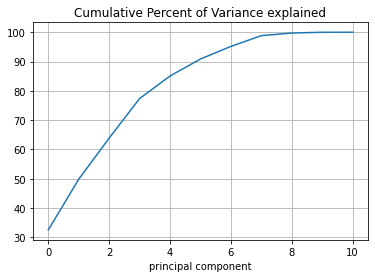

In [15]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

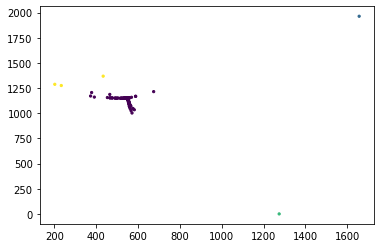

In [16]:
#plot in cluster distance space
r = cl.transform(results)
plt.scatter(r[:,3],r[:,2],c=cl.labels_, s=5)

In [17]:
#elbow method
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [2, 3,4,5,6,7,8,9,10,12,15,20,25, 40]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz

Text(0.5, 1.0, 'Calinski Harabaz Scores')

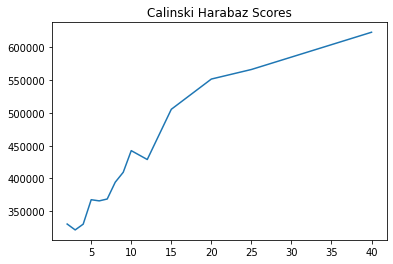

In [18]:
plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

Text(0, 0.5, 'within cluster sum of squares')

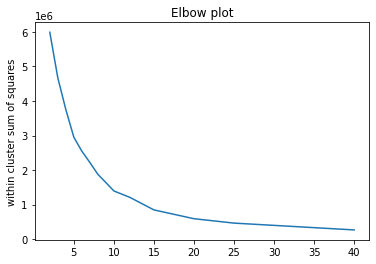

In [19]:
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')


In [20]:
#optmal number of clusters is around 12
cl = KMeans(12)
cl.fit(results)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
#outlier removal



def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)

In [22]:
thresholds = np.linspace(.3,3, 20)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz

Text(0.5, 1.0, 'Calinski Harabaz Scores as std threshold changes')

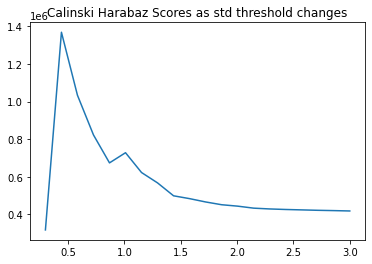

In [23]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [24]:
#empirical best threshold .75 stdev
newresults, labels = remove_outliers(results, cl,.8)

ERROR! Session/line number was not unique in database. History logging moved to new session 59


(-15.0, 10.0)

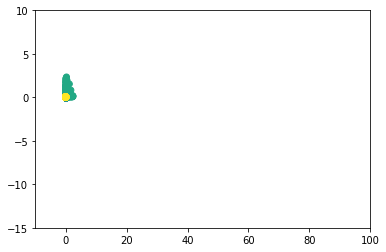

In [25]:
plt.scatter(newresults[:,0],newresults[:,1],c=labels)
plt.xlim(-10,100)
plt.ylim(-15,10)

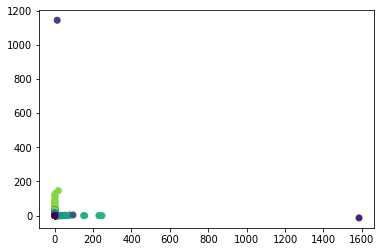

In [26]:

plt.scatter(results[:,0],results[:,1],c=cl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)

In [0]:
newcl = KMeans(10).fit(newresults)

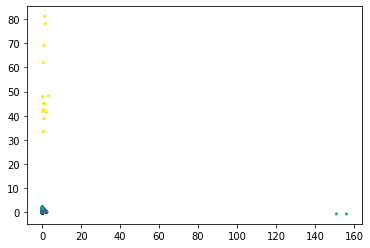

In [28]:
plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_, s=5)

# DB SCAN

In [2]:
dbscan_data = pd.read_csv('/content/gdrive/My Drive/FinalData/final_data.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
dbscan_data .head(5)

,address,no_of_in_transactions,tot_ether_recieved,no_of_out_transactions,tot_ether_sent,tot_token_value_recieved,tot_token_value_sent,time_b/w_out_txn_x,time_b/w_out_txn_y,active_months,monthly_out_txn,monthly_in_txn
0,0xd4f8e83864c80ea703dd148c78b937cbec200243,9,27000000000000000,97,19448289831436946,9.393942e+06,9.393942e+06,1.156452e+05,1.434797e+04,2,48.500000,9.000000
1,0xd9052a62ee61eec200c1972aa2a19fa3d5396b6d,14,10342497563429364,32,0,1.870353e+11,1.870353e+11,1.042143e+06,4.736983e+05,6,5.500000,2.500000
2,0xe6b4a32cc822980d652bb185b33db6be69d39a13,17,16776853680000000000,86,21009302000000000000,4.639691e+22,4.260856e+22,1.320557e+06,1.653896e+05,5,21.500000,3.400000
3,0x9f265a9675dea8f97139015f62c84af1f6d687ae,15,2100000000000000000,3,2099000000000000000,2.000000e+20,2.000000e+20,3.701651e+05,1.252319e+06,4,1.500000,5.000000
4,0xbad9298ef9a0c40ed1fb299a5e42269589aa15af,142,17850287239292549380,57,17813824239292549380,3.000000e+18,1.000000e+20,2.403451e+05,5.987940e+05,14,4.384615,10.923077


In [0]:
data = dbscan_data.iloc[:80000,1:]

In [4]:
pipe = Pipeline([('scale', StandardScaler()), ('PCA', PCA(n_components=6))])

results = pipe.fit_transform(data)

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=.2)

db.fit(results)

print(db.components_.shape)

labels = np.unique(db.labels_)
indices = db.core_sample_indices_

sample, outliers = results[indices], np.delete(results, indices, axis=0)
s_labels, o_labels = db.labels_[indices], np.delete(db.labels_, indices, axis=0)

(76787, 6)


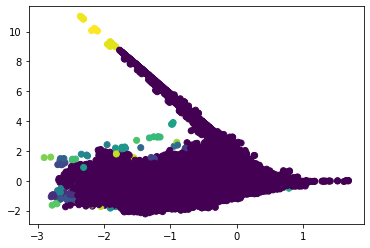

In [5]:
# plt.scatter(outliers[:,0], outliers[:,1], c='black', alpha=.2)
plt.scatter(sample[:,3], sample[:,4], c= s_labels)

# plt.xlim(-1,30)
# plt.ylim(-1,20)

(-1.0, 1.0)

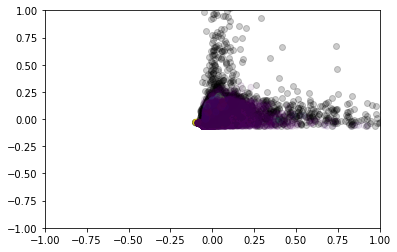

In [6]:

plt.scatter(outliers[:,0], outliers[:,1], c='black', alpha=.2)
plt.scatter(sample[:,0], sample[:,1], c= s_labels, alpha= .1)

plt.xlim(-1,1)
plt.ylim(-1,1)

In [10]:
np.unique(db.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56])